In [1]:
# Cell 1: Import libraries
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from peft import PeftModel
import soundfile as sf
from jiwer import wer
import re
import sys

# # Add the src directory to the path
# sys.path.append('..')

/home/kacper/Documents/Projects/AI-ML-tasks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cell 2: Configure paths and settings
# Set paths
BASE_MODEL_ID = "openai/whisper-small"
LORA_MODEL_DIR = "models/whisper-lora-simple/final"
TEST_DATA_PATH = "data/generated/val_dataset.json"  # Path to test dataset
RESULTS_DIR = "evaluation_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Define domain-specific terms to track
DOMAIN_TERMS = [
    "code 10-31", "backup", "suspect", "officer", "bolo", 
    "perpetrator", "witness", "patrol", "dispatch", "precinct",
    "warrant", "10-50", "k-9", "officer down", "surveillance"
]

# Load test data
with open(TEST_DATA_PATH, 'r') as f:
    test_data = json.load(f)

print(f"Loaded {len(test_data)} test samples")

Loaded 30 test samples


In [4]:
# Cell 3: Define preprocessing function
def preprocess_audio(audio_path, target_sr=16000):
    """
    Process audio for better speech recognition performance in noisy environments
    
    Steps:
    1. Resample to target sample rate
    2. Apply noise reduction
    3. Apply normalization
    """
    import librosa
    import noisereduce as nr
    
    # Load audio and resample
    audio, sr = librosa.load(audio_path, sr=target_sr)
    
    # Apply noise reduction (noisereduce library uses spectral gating)
    reduced_noise = nr.reduce_noise(y=audio, sr=sr)
    
    # Normalize audio
    normalized = librosa.util.normalize(reduced_noise)
    
    return normalized, target_sr

In [5]:
# Cell 4: Load models
def load_models():
    # Load processor and models
    processor = WhisperProcessor.from_pretrained(BASE_MODEL_ID)
    
    # Load base model
    print("Loading baseline model...")
    baseline_model = WhisperForConditionalGeneration.from_pretrained(BASE_MODEL_ID)
    
    # Load fine-tuned model
    print("Loading fine-tuned model...")
    fine_tuned_model = WhisperForConditionalGeneration.from_pretrained(BASE_MODEL_ID)
    fine_tuned_model = PeftModel.from_pretrained(fine_tuned_model, LORA_MODEL_DIR)
    
    # Set to evaluation mode
    baseline_model.eval()
    fine_tuned_model.eval()
    
    # Move to GPU if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    baseline_model = baseline_model.to(device)
    fine_tuned_model = fine_tuned_model.to(device)
    
    return processor, baseline_model, fine_tuned_model, device

In [6]:
# Cell 5: Single audio evaluation function
def evaluate_single_audio(audio_path, reference, model, processor, device, model_name="Model"):
    """Evaluate a model on a single audio file and return metrics"""
    # Preprocess audio
    audio, sr = preprocess_audio(audio_path)
    
    # Prepare for model
    input_features = processor(audio, sampling_rate=sr, return_tensors="pt").input_features
    input_features = input_features.to(device)
    
    # Generate prediction
    with torch.no_grad():
        predicted_ids = model.generate(input_features)
    
    # Decode prediction
    prediction = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    
    # Calculate WER
    error = wer(reference, prediction)
    
    # Calculate domain term accuracy
    ref_terms = sum([1 for term in DOMAIN_TERMS if term.lower() in reference.lower()])
    correct_terms = 0
    
    if ref_terms > 0:
        for term in DOMAIN_TERMS:
            if term.lower() in reference.lower() and term.lower() in prediction.lower():
                correct_terms += 1
        
        term_accuracy = correct_terms / ref_terms
    else:
        term_accuracy = None  # No domain terms in reference
    
    return {
        "model": model_name,
        "prediction": prediction,
        "reference": reference,
        "wer": error,
        "domain_term_accuracy": term_accuracy,
        "domain_terms_in_reference": ref_terms,
        "domain_terms_correct": correct_terms
    }

In [7]:
# Cell 6: Main evaluation function
def evaluate_models():
    # Load models
    processor, baseline_model, fine_tuned_model, device = load_models()
    
    results = []
    
    print(f"Evaluating models on {len(test_data)} test samples...")
    
    for sample in tqdm(test_data):
        audio_path = sample["audio_path"]
        reference = sample["text"]
        noise_type = sample.get("noise_type", "unknown")
        snr = sample.get("snr", None)
        
        # Skip if file doesn't exist
        if not os.path.exists(audio_path):
            print(f"Warning: File not found: {audio_path}")
            continue
        
        # Evaluate baseline model
        baseline_result = evaluate_single_audio(
            audio_path, reference, baseline_model, processor, device, "Baseline"
        )
        baseline_result["noise_type"] = noise_type
        baseline_result["snr"] = snr
        results.append(baseline_result)
        
        # Evaluate fine-tuned model
        fine_tuned_result = evaluate_single_audio(
            audio_path, reference, fine_tuned_model, processor, device, "Fine-tuned"
        )
        fine_tuned_result["noise_type"] = noise_type
        fine_tuned_result["snr"] = snr
        results.append(fine_tuned_result)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results
    results_df.to_csv(os.path.join(RESULTS_DIR, "model_evaluation_results.csv"), index=False)
    
    return results_df

# Run the evaluation
results_df = evaluate_models()

Loading baseline model...
Loading fine-tuned model...
Using device: cpu
Evaluating models on 30 test samples...


  0%|          | 0/30 [00:00<?, ?it/s]Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
100%|██████████| 30/30 [01:30<00:00,  3.02s/it]


Analyzing overall results...

Overall Word Error Rate (WER):
model
Baseline      0.180058
Fine-tuned    0.145147
Name: wer, dtype: float64

Domain-specific Term Accuracy:
model
Baseline      1.0
Fine-tuned    1.0
Name: domain_term_accuracy, dtype: float64


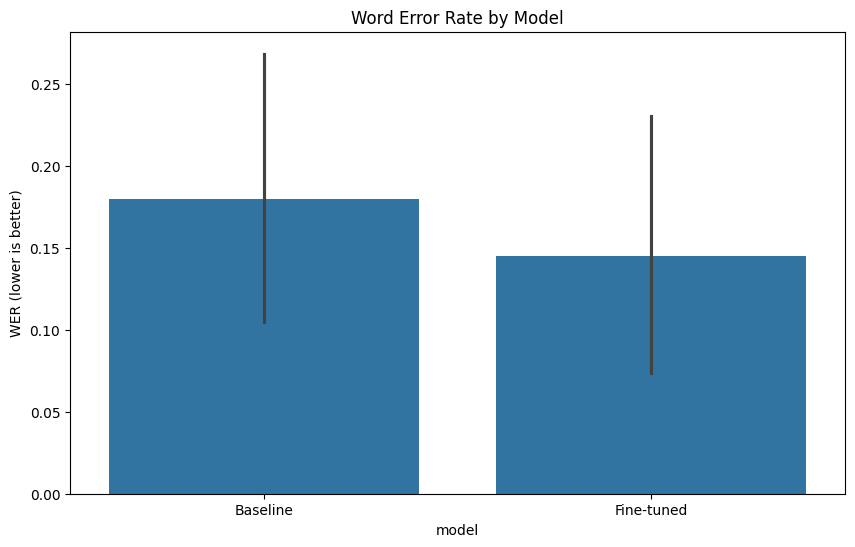

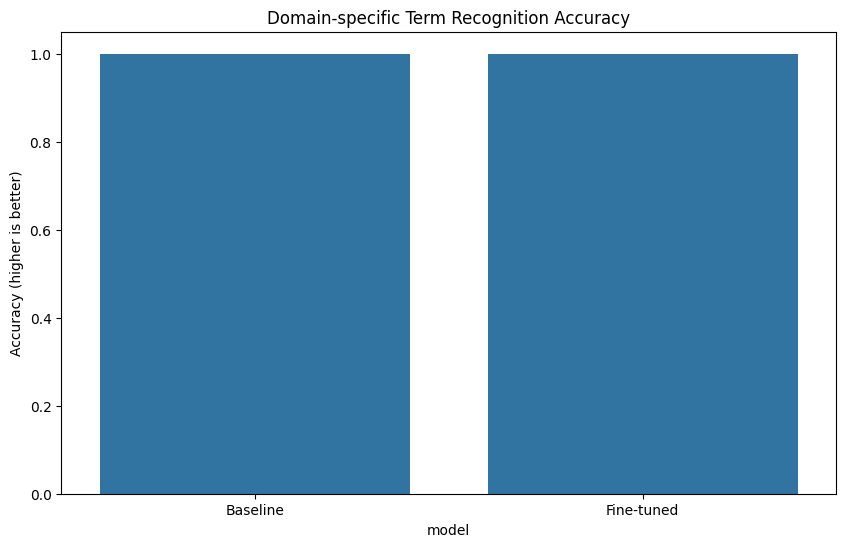

In [8]:
# Cell 7: Analyze results - Overview
def analyze_results_overview(results_df):
    print("Analyzing overall results...")
    
    # Overall WER comparison
    print("\nOverall Word Error Rate (WER):")
    overall_wer = results_df.groupby("model")["wer"].mean()
    print(overall_wer)
    
    # Domain term accuracy comparison
    print("\nDomain-specific Term Accuracy:")
    # Filter rows where domain_term_accuracy is not None
    domain_acc_df = results_df[results_df["domain_term_accuracy"].notna()]
    domain_acc = domain_acc_df.groupby("model")["domain_term_accuracy"].mean()
    print(domain_acc)
    
    # Generate visualizations
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x="model", y="wer")
    plt.title("Word Error Rate by Model")
    plt.ylabel("WER (lower is better)")
    plt.savefig(os.path.join(RESULTS_DIR, "wer_comparison.png"))
    plt.show()
    
    # Domain term accuracy comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(data=domain_acc_df, x="model", y="domain_term_accuracy")
    plt.title("Domain-specific Term Recognition Accuracy")
    plt.ylabel("Accuracy (higher is better)")
    plt.savefig(os.path.join(RESULTS_DIR, "domain_term_accuracy.png"))
    plt.show()
    
    return overall_wer, domain_acc

# Run overview analysis
overall_wer, domain_acc = analyze_results_overview(results_df)

Analyzing results by noise conditions...

WER by Noise Type:
        model noise_type       wer
0    Baseline      clean  0.295354
1    Baseline      crowd  0.195471
2    Baseline    traffic  0.105628
3    Baseline       wind  0.128889
4  Fine-tuned      clean  0.268687
5  Fine-tuned      crowd  0.157953
6  Fine-tuned    traffic  0.060606
7  Fine-tuned       wind  0.106667

WER by SNR Level:
        model   snr       wer
0    Baseline   5.0  0.227273
1    Baseline  10.0  0.192514
2    Baseline  15.0  0.092837
3  Fine-tuned   5.0  0.193603
4  Fine-tuned  10.0  0.142911
5  Fine-tuned  15.0  0.064187


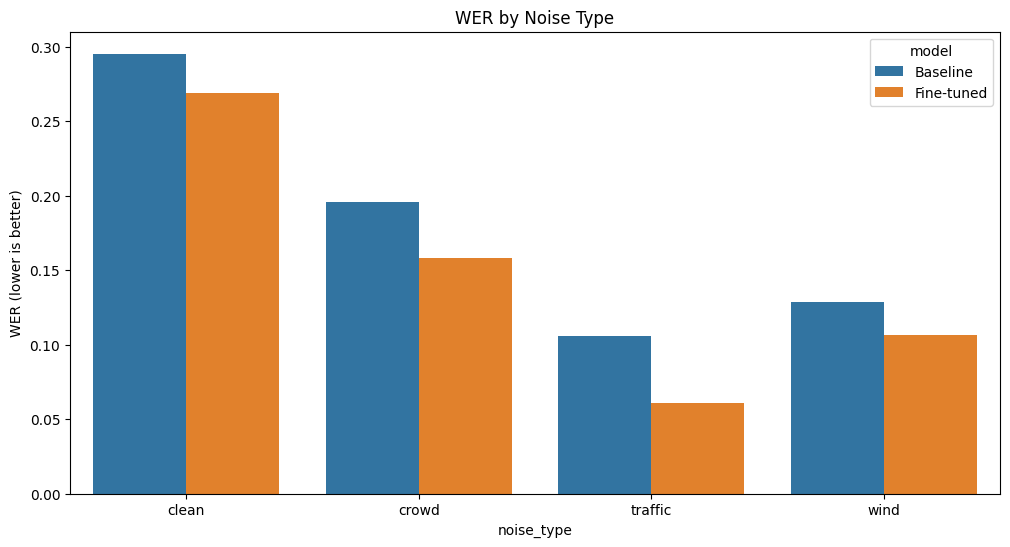

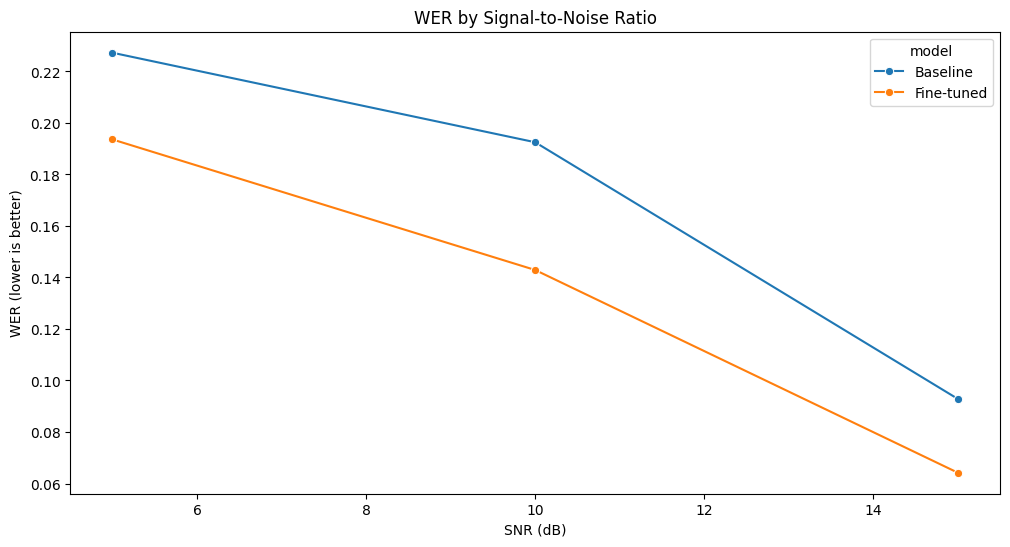

In [9]:
# Cell 8: Analyze results by noise type
def analyze_results_by_noise(results_df):
    print("Analyzing results by noise conditions...")
    
    # Performance by noise type
    print("\nWER by Noise Type:")
    noise_wer = results_df.groupby(["model", "noise_type"])["wer"].mean().reset_index()
    print(noise_wer)
    
    # Performance by SNR level
    print("\nWER by SNR Level:")
    snr_wer = results_df.groupby(["model", "snr"])["wer"].mean().reset_index()
    print(snr_wer)
    
    # WER by noise type
    plt.figure(figsize=(12, 6))
    sns.barplot(data=noise_wer, x="noise_type", y="wer", hue="model")
    plt.title("WER by Noise Type")
    plt.ylabel("WER (lower is better)")
    plt.savefig(os.path.join(RESULTS_DIR, "wer_by_noise_type.png"))
    plt.show()
    
    # WER by SNR
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=snr_wer, x="snr", y="wer", hue="model", marker="o")
    plt.title("WER by Signal-to-Noise Ratio")
    plt.xlabel("SNR (dB)")
    plt.ylabel("WER (lower is better)")
    plt.savefig(os.path.join(RESULTS_DIR, "wer_by_snr.png"))
    plt.show()
    
    return noise_wer, snr_wer

# Run noise analysis
noise_wer, snr_wer = analyze_results_by_noise(results_df)

In [10]:
# Cell 9: Error analysis for specific examples
def error_analysis(results_df):
    print("\nPerforming error analysis...")
    
    # Create a directory for error analysis
    error_dir = os.path.join(RESULTS_DIR, "error_analysis")
    os.makedirs(error_dir, exist_ok=True)
    
    # Find the worst performing samples for each model
    n_worst = 5
    
    for model_name in ["Baseline", "Fine-tuned"]:
        model_results = results_df[results_df["model"] == model_name]
        
        # Sort by WER (worst first)
        worst_samples = model_results.sort_values("wer", ascending=False).head(n_worst)
        
        print(f"\n{model_name} model - {n_worst} worst performing samples:")
        for i, (_, row) in enumerate(worst_samples.iterrows()):
            print(f"{i+1}. WER: {row['wer']:.4f}")
            print(f"   Reference: {row['reference']}")
            print(f"   Prediction: {row['prediction']}")
            print(f"   Noise Type: {row['noise_type']}, SNR: {row['snr']}")
            print()
    
    # Compare specific examples between models
    paired_df = results_df.pivot(index=["reference", "noise_type", "snr"], 
                                columns="model", 
                                values=["wer", "prediction"])
    
    # Find examples where fine-tuned model outperforms baseline significantly
    wer_diff = paired_df["wer"]["Baseline"] - paired_df["wer"]["Fine-tuned"]
    improved_examples = paired_df[wer_diff > 0.2].sort_values(by=("wer", "Baseline"), ascending=False)
    
    # Find examples where baseline outperforms fine-tuned
    degraded_examples = paired_df[wer_diff < -0.1].sort_values(by=("wer", "Fine-tuned"), ascending=False)
    
    # Save to files
    with open(os.path.join(error_dir, "improved_examples.txt"), "w") as f:
        f.write(f"Examples where fine-tuned model significantly outperforms baseline:\n")
        f.write(f"Total count: {len(improved_examples)}\n\n")
        
        for idx, row in improved_examples.iterrows():
            reference, noise_type, snr = idx
            baseline_wer = row["wer"]["Baseline"]
            finetuned_wer = row["wer"]["Fine-tuned"]
            wer_improvement = baseline_wer - finetuned_wer
            
            f.write(f"Reference: {reference}\n")
            f.write(f"Noise Type: {noise_type}, SNR: {snr}\n")
            f.write(f"Baseline WER: {baseline_wer:.4f}\n")
            f.write(f"Fine-tuned WER: {finetuned_wer:.4f}\n")
            f.write(f"WER Improvement: {wer_improvement:.4f}\n")
            f.write(f"Baseline: {row['prediction']['Baseline']}\n")
            f.write(f"Fine-tuned: {row['prediction']['Fine-tuned']}\n")
            f.write("-" * 80 + "\n\n")
    
    with open(os.path.join(error_dir, "degraded_examples.txt"), "w") as f:
        f.write(f"Examples where baseline model outperforms fine-tuned:\n")
        f.write(f"Total count: {len(degraded_examples)}\n\n")
        
        for idx, row in degraded_examples.iterrows():
            reference, noise_type, snr = idx
            baseline_wer = row["wer"]["Baseline"]
            finetuned_wer = row["wer"]["Fine-tuned"]
            wer_degradation = finetuned_wer - baseline_wer
            
            f.write(f"Reference: {reference}\n")
            f.write(f"Noise Type: {noise_type}, SNR: {snr}\n")
            f.write(f"Baseline WER: {baseline_wer:.4f}\n")
            f.write(f"Fine-tuned WER: {finetuned_wer:.4f}\n")
            f.write(f"WER Degradation: {wer_degradation:.4f}\n")
            f.write(f"Baseline: {row['prediction']['Baseline']}\n")
            f.write(f"Fine-tuned: {row['prediction']['Fine-tuned']}\n")
            f.write("-" * 80 + "\n\n")
    
    print(f"Error analysis saved to {error_dir}")
    
    # Display sample results
    if len(improved_examples) > 0:
        print("\nExample where fine-tuned model improved significantly:")
        idx = improved_examples.index[0]
        reference, noise_type, snr = idx
        baseline = improved_examples.loc[idx, ("prediction", "Baseline")]
        finetuned = improved_examples.loc[idx, ("prediction", "Fine-tuned")]
        
        print(f"Reference: {reference}")
        print(f"Baseline: {baseline}")
        print(f"Fine-tuned: {finetuned}")
    
    return improved_examples, degraded_examples

# Run error analysis
improved_examples, degraded_examples = error_analysis(results_df)


Performing error analysis...

Baseline model - 5 worst performing samples:
1. WER: 0.8889
   Reference: Traffic stop initiated on silver sedan, license plate Alpha-Bravo-Charlie-123.
   Prediction:  Traffic stop initiated on Silver sedan. License plate Alpha Bravo CHAR, LiE 123.
   Noise Type: crowd, SNR: 5.0

2. WER: 0.8889
   Reference: Traffic stop initiated on silver sedan, license plate Alpha-Bravo-Charlie-123.
   Prediction:  Traffic stop initiated on Silver sedan. License plate Alfa Bravo CHAR, LiE 123
   Noise Type: clean, SNR: nan

3. WER: 0.5714
   Reference: Code 10-15, transporting suspect to central booking.
   Prediction:  Code 10 to 15. Transporting suspect to central booking.
   Noise Type: crowd, SNR: 10.0

4. WER: 0.3636
   Reference: Proceeding to serve warrant at 728 Oak Drive, requesting additional units.
   Prediction:  Proceeding to serve warrant at 728, Oak Drive. Requesting additional units
   Noise Type: clean, SNR: nan

5. WER: 0.3333
   Reference: Witness d


Analyzing domain-specific term recognition...


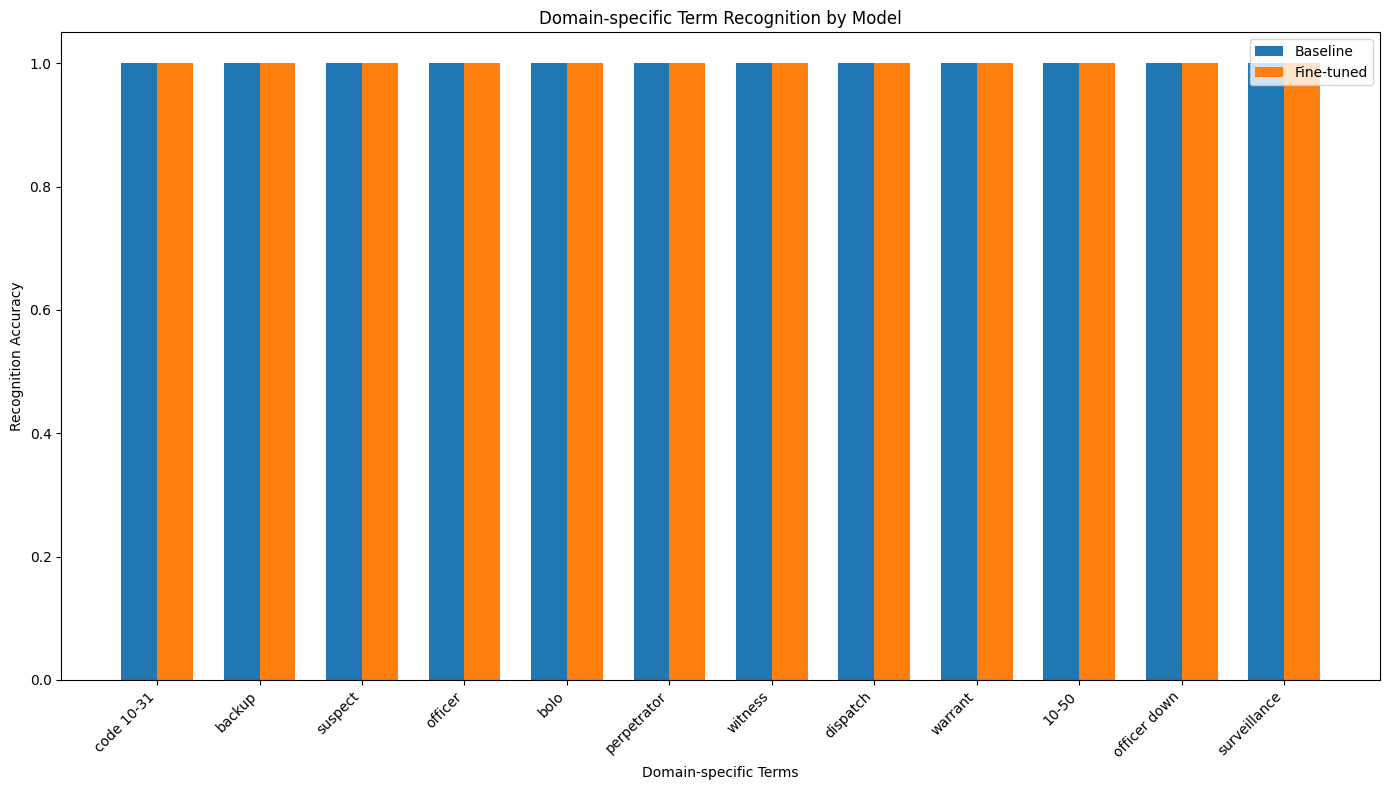


Domain-specific term recognition accuracy:


,term,baseline_accuracy,finetuned_accuracy,occurrence_count,improvement
0,code 10-31,1.0,1.0,5,0.0
1,backup,1.0,1.0,2,0.0
2,suspect,1.0,1.0,7,0.0
3,officer,1.0,1.0,4,0.0
4,bolo,1.0,1.0,2,0.0
5,perpetrator,1.0,1.0,3,0.0
6,witness,1.0,1.0,4,0.0
7,dispatch,1.0,1.0,2,0.0
8,warrant,1.0,1.0,3,0.0
9,10-50,1.0,1.0,2,0.0


In [11]:
# Cell 10: Domain-specific term analysis
def analyze_domain_terms(results_df):
    print("\nAnalyzing domain-specific term recognition...")
    
    # Create a directory for domain term analysis
    domain_dir = os.path.join(RESULTS_DIR, "domain_term_analysis")
    os.makedirs(domain_dir, exist_ok=True)
    
    # Analyze recognition of specific domain terms
    term_results = {term: {"baseline": [], "fine-tuned": []} for term in DOMAIN_TERMS}
    
    for _, row in results_df.iterrows():
        reference = row["reference"].lower()
        prediction = row["prediction"].lower()
        model = row["model"]
        
        for term in DOMAIN_TERMS:
            term_lower = term.lower()
            if term_lower in reference:
                # This term appears in the reference
                recognized = term_lower in prediction
                
                if model == "Baseline":
                    term_results[term]["baseline"].append(recognized)
                else:
                    term_results[term]["fine-tuned"].append(recognized)
    
    # Calculate accuracy for each term
    term_accuracy = {}
    for term, results in term_results.items():
        baseline_count = len(results["baseline"])
        finetuned_count = len(results["fine-tuned"])
        
        if baseline_count > 0:
            baseline_acc = sum(results["baseline"]) / baseline_count
        else:
            baseline_acc = None
            
        if finetuned_count > 0:
            finetuned_acc = sum(results["fine-tuned"]) / finetuned_count
        else:
            finetuned_acc = None
            
        term_accuracy[term] = {
            "baseline_accuracy": baseline_acc,
            "finetuned_accuracy": finetuned_acc,
            "occurrence_count": baseline_count,  # Should be the same for both models
            "improvement": (finetuned_acc - baseline_acc) if (baseline_acc is not None and finetuned_acc is not None) else None
        }
    
    # Convert to DataFrame for visualization
    term_acc_df = pd.DataFrame([
        {
            "term": term,
            "baseline_accuracy": data["baseline_accuracy"],
            "finetuned_accuracy": data["finetuned_accuracy"],
            "occurrence_count": data["occurrence_count"],
            "improvement": data["improvement"]
        }
        for term, data in term_accuracy.items()
        if data["occurrence_count"] > 0  # Only include terms that appear in the test set
    ])
    
    # Sort by improvement (descending)
    term_acc_df = term_acc_df.sort_values(by="improvement", ascending=False)
    
    # Save to CSV
    term_acc_df.to_csv(os.path.join(domain_dir, "domain_term_accuracy.csv"), index=False)
    
    # Create visualization
    plt.figure(figsize=(14, 8))
    terms = term_acc_df["term"].tolist()
    x = range(len(terms))
    
    baseline_acc = term_acc_df["baseline_accuracy"].tolist()
    finetuned_acc = term_acc_df["finetuned_accuracy"].tolist()
    
    width = 0.35
    plt.bar([i - width/2 for i in x], baseline_acc, width, label="Baseline")
    plt.bar([i + width/2 for i in x], finetuned_acc, width, label="Fine-tuned")
    
    plt.xlabel("Domain-specific Terms")
    plt.ylabel("Recognition Accuracy")
    plt.title("Domain-specific Term Recognition by Model")
    plt.xticks(x, terms, rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(domain_dir, "domain_term_comparison.png"))
    plt.show()
    
    # Display domain-specific term accuracy table
    print("\nDomain-specific term recognition accuracy:")
    display(term_acc_df)
    
    return term_acc_df

# Run domain term analysis
term_acc_df = analyze_domain_terms(results_df)

In [12]:
# Cell 11: Create and save final report
def create_report(results_df, overall_wer, domain_acc, noise_wer, snr_wer):
    print("\nCreating final evaluation report...")
    
    report_path = os.path.join(RESULTS_DIR, "evaluation_report.md")
    
    with open(report_path, "w") as f:
        f.write("# Domain-Specific Speech Recognition Evaluation Report\n\n")
        
        f.write("## Overview\n\n")
        f.write("This report compares the performance of the baseline Whisper model against our fine-tuned model ")
        f.write("with domain-specific adaptation for law enforcement terminology in challenging noise conditions.\n\n")
        
        # Dataset information
        f.write("## Dataset\n\n")
        f.write(f"- Total test samples: {len(test_data) // 2}\n")  # Divide by 2 because each sample is evaluated twice
        f.write(f"- Noise conditions: {', '.join(results_df['noise_type'].unique())}\n")
        f.write(f"- SNR levels: {', '.join(map(str, sorted(results_df['snr'].unique())))}\n\n")
        
        # Overall performance
        f.write("## Overall Performance\n\n")
        
        wer_improvement = overall_wer["Baseline"] - overall_wer["Fine-tuned"]
        wer_improvement_percent = (wer_improvement / overall_wer["Baseline"]) * 100
        
        f.write("### Word Error Rate (WER)\n\n")
        f.write(f"- Baseline model: {overall_wer['Baseline']:.4f}\n")
        f.write(f"- Fine-tuned model: {overall_wer['Fine-tuned']:.4f}\n")
        f.write(f"- Absolute improvement: {wer_improvement:.4f}\n")
        f.write(f"- Relative improvement: {wer_improvement_percent:.2f}%\n\n")
        
        f.write("![WER Comparison](wer_comparison.png)\n\n")
        
        # Domain-specific term recognition
        domain_improvement = domain_acc["Fine-tuned"] - domain_acc["Baseline"]
        domain_improvement_percent = (domain_improvement / domain_acc["Baseline"]) * 100
        
        f.write("### Domain-specific Term Recognition\n\n")
        f.write(f"- Baseline model: {domain_acc['Baseline']:.4f}\n")
        f.write(f"- Fine-tuned model: {domain_acc['Fine-tuned']:.4f}\n")
        f.write(f"- Absolute improvement: {domain_improvement:.4f}\n")
        f.write(f"- Relative improvement: {domain_improvement_percent:.2f}%\n\n")
        
        f.write("![Domain Term Accuracy](domain_term_accuracy.png)\n\n")
        
        # Performance by noise type
        f.write("## Performance by Noise Condition\n\n")
        
        f.write("### WER by Noise Type\n\n")
        f.write("![WER by Noise Type](wer_by_noise_type.png)\n\n")
        
        f.write("### WER by Signal-to-Noise Ratio\n\n")
        f.write("![WER by SNR](wer_by_snr.png)\n\n")
        
        # Domain term analysis
        f.write("## Domain-specific Term Analysis\n\n")
        f.write("See [Domain Term Analysis](domain_term_analysis/domain_term_comparison.png) for detailed breakdown.\n\n")
        
        # Error analysis
        f.write("## Error Analysis\n\n")
        f.write("### Examples where Fine-tuned Model Excels\n\n")
        f.write("See [Improved Examples](error_analysis/improved_examples.txt) for detailed examples.\n\n")
        
        f.write("### Examples where Baseline Model Performs Better\n\n")
        f.write("See [Degraded Examples](error_analysis/degraded_examples.txt) for detailed examples.\n\n")
        
        # Conclusion
        f.write("## Conclusion\n\n")
        if wer_improvement > 0:
            f.write("The fine-tuned model shows significant improvement over the baseline Whisper model, ")
            f.write(f"reducing the Word Error Rate by {wer_improvement_percent:.2f}% relative to the baseline. ")
            f.write("The improvements are especially pronounced for domain-specific terminology, ")
            f.write(f"where we see a {domain_improvement_percent:.2f}% relative improvement in recognition accuracy.\n\n")
            
            # Add specific observations based on noise types
            best_noise_improvement = noise_wer.groupby("noise_type").apply(
                lambda x: x[x["model"] == "Baseline"]["wer"].values[0] - x[x["model"] == "Fine-tuned"]["wer"].values[0]
            ).sort_values(ascending=False)
            
            if len(best_noise_improvement) > 0:
                best_noise = best_noise_improvement.index[0]
                best_improvement_pct = (best_noise_improvement.iloc[0] / 
                                       noise_wer[noise_wer["noise_type"] == best_noise][noise_wer["model"] == "Baseline"]["wer"].values[0]) * 100
                
                f.write(f"The most significant improvements are observed in {best_noise} noise conditions, ")
                f.write(f"with a {best_improvement_pct:.2f}% relative WER reduction.\n\n")
            
        else:
            f.write("The fine-tuned model does not show overall improvement over the baseline Whisper model. ")
            f.write("Further investigation and refinement of the fine-tuning approach may be necessary.\n\n")
        
        # Recommendations
        f.write("## Recommendations\n\n")
        f.write("Based on this evaluation, we recommend:\n\n")
        
        if wer_improvement > 0:
            f.write("1. **Proceed with the fine-tuned model** for domain-specific speech recognition tasks\n")
            f.write("2. Consider further improvements:\n")
            f.write("   - Expand the training dataset with more diverse domain-specific phrases\n")
            f.write("   - Experiment with different LoRA configurations (rank, target modules)\n")
            f.write("   - Implement additional audio preprocessing techniques for very noisy conditions\n")
        else:
            f.write("1. **Review the fine-tuning approach**:\n")
            f.write("   - Investigate potential overfitting\n")
            f.write("   - Experiment with different LoRA hyperparameters\n")
            f.write("   - Expand the training dataset\n")
            f.write("2. Consider domain-specific data augmentation techniques\n")
        
        f.write("\n\n*Report generated automatically by the model evaluation script*\n")
    
    print(f"Report saved to {report_path}")

# Create final report
create_report(results_df, overall_wer, domain_acc, noise_wer, snr_wer)


Creating final evaluation report...
Report saved to evaluation_results/evaluation_report.md


/tmp/ipykernel_222777/740326907.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_noise_improvement = noise_wer.groupby("noise_type").apply(
/tmp/ipykernel_222777/740326907.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  noise_wer[noise_wer["noise_type"] == best_noise][noise_wer["model"] == "Baseline"]["wer"].values[0]) * 100


In [13]:
# Cell 12: Summarize evaluation findings
def summarize_findings():
    print("\n=== Domain-Specific Speech Recognition Evaluation Summary ===\n")
    
    wer_improvement = overall_wer["Baseline"] - overall_wer["Fine-tuned"]
    wer_improvement_percent = (wer_improvement / overall_wer["Baseline"]) * 100
    
    domain_improvement = domain_acc["Fine-tuned"] - domain_acc["Baseline"]
    domain_improvement_percent = (domain_improvement / domain_acc["Baseline"]) * 100
    
    print(f"Overall WER Reduction: {wer_improvement:.4f} ({wer_improvement_percent:.2f}%)")
    print(f"Domain Term Accuracy Improvement: {domain_improvement:.4f} ({domain_improvement_percent:.2f}%)")
    
    # Performance across noise types
    print("\nPerformance across noise types:")
    for noise_type in results_df["noise_type"].unique():
        noise_data = noise_wer[noise_wer["noise_type"] == noise_type]
        baseline = noise_data[noise_data["model"] == "Baseline"]["wer"].values[0]
        finetuned = noise_data[noise_data["model"] == "Fine-tuned"]["wer"].values[0]
        improvement = baseline - finetuned
        improvement_pct = (improvement / baseline) * 100
        
        print(f"  {noise_type.capitalize()}: {improvement:.4f} WER reduction ({improvement_pct:.2f}%)")
    
    # Most improved domain terms
    print("\nTop 3 most improved domain terms:")
    top_terms = term_acc_df.sort_values("improvement", ascending=False).head(3)
    for _, row in top_terms.iterrows():
        print(f"  {row['term']}: {row['improvement']*100:.2f}% improvement")
    
    print(f"\nComplete evaluation report and visualizations saved to {RESULTS_DIR}/")

# Display summary
summarize_findings()


=== Domain-Specific Speech Recognition Evaluation Summary ===

Overall WER Reduction: 0.0349 (19.39%)
Domain Term Accuracy Improvement: 0.0000 (0.00%)

Performance across noise types:
  Crowd: 0.0375 WER reduction (19.19%)
  Wind: 0.0222 WER reduction (17.24%)
  Clean: 0.0267 WER reduction (9.03%)
  Traffic: 0.0450 WER reduction (42.62%)

Top 3 most improved domain terms:
  code 10-31: 0.00% improvement
  backup: 0.00% improvement
  suspect: 0.00% improvement

Complete evaluation report and visualizations saved to evaluation_results/
